# 7-MonteCarlo Sampling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/ja/7-MonteCarloSampling.ipynb)

OpenJij は Simulated annealing を実行しますが、温度を一定に保てば、その温度でのボルツマン分布

$$
p(\{\sigma\}) = \frac{\exp(-\beta E(\{\sigma\}))}{Z},~Z = \sum_{\{\sigma\}}\exp(-\beta E(\{\sigma\}))
$$

からスピン配列をサンプルすることができます。

以下では全結合の強磁性イジングモデル

$$
E(\{\sigma\}) = \frac{J}{N}\sum_{i<j}\sigma_i \sigma_j (J < 0)
$$

を取り扱ってみます。項をシステムサイズの$N$で割っているのはハミルトニアンを$N$と同じ程度の大きさに規格化するためです。$J$はここでは-1としています。


In [1]:
import openjij as oj
import numpy as np
sampler = oj.SASampler(num_reads=100)

def fully_connected(n):
    h, J = {}, {}
    for i in range(n-1):
        for j in range(i+1, n):
            J[i, j] = -1/n
    return h, J

h, J = fully_connected(n=500)

各温度での磁化

$$ m = \frac{1}{N}\sum_{i}\sigma_i$$

を計算してみましょう。1に近いほどスピンが揃っている状態 (強磁性)、0に近いほどスピンがばらばらな状態 (常磁性)を表しています。
温度を一定にしてOpenJijを回してみると、温度が1.0付近で磁化の値が0に近づいていくのが分かります。温度を上げるとスピンがばらばらになりやすいためです。

In [3]:
temp_list = np.linspace(0.01, 2, 30)

mag, mag_std = [], []
for temp in temp_list:
    print("temperature = {}...".format(temp))
    beta = 1.0/temp
    schedule = [[beta, 100]]
    response = sampler.sample_ising(h, J, schedule=schedule)
    mag_list = [np.abs(np.mean(state)) for state in response.states]
    mag_std.append(np.std(mag_list))
    mag.append(np.mean(mag_list))

print("simulation completed.")

temperature = 0.01...
temperature = 0.07862068965517241...
temperature = 0.14724137931034484...
temperature = 0.21586206896551724...
temperature = 0.28448275862068967...
temperature = 0.3531034482758621...
temperature = 0.42172413793103447...
temperature = 0.4903448275862069...
temperature = 0.5589655172413793...
temperature = 0.6275862068965518...
temperature = 0.6962068965517242...
temperature = 0.7648275862068966...
temperature = 0.8334482758620689...
temperature = 0.9020689655172414...
temperature = 0.9706896551724138...
temperature = 1.0393103448275862...
temperature = 1.1079310344827586...
temperature = 1.176551724137931...
temperature = 1.2451724137931035...
temperature = 1.313793103448276...
temperature = 1.3824137931034484...
temperature = 1.4510344827586208...
temperature = 1.5196551724137932...
temperature = 1.5882758620689656...
temperature = 1.6568965517241379...
temperature = 1.7255172413793103...
temperature = 1.7941379310344827...
temperature = 1.8627586206896551...
tem

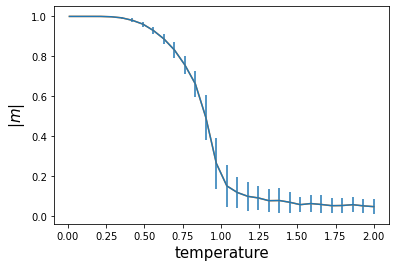

In [4]:
import matplotlib.pyplot as plt

plt.errorbar(temp_list, mag, yerr=mag_std)
plt.plot(temp_list, mag)
plt.xlabel('temperature', fontsize=15)
plt.ylabel(r'$|m|$', fontsize=15)
plt.show()

ある温度を境に値が大きく変わるこのような現象は**相転移**とよばれる現象で、今回の模型では(システムのサイズを無限に近づけると)温度が1.0のときに相転移がおきることが理論的に証明されています。

ただ、実際のモデルではどの程度の温度で相転移が起きるか理論的に計算できない場合が多々あるため、モンテカルロシミュレーションを用いて相転移に関する性質を数値的に研究する手法が多く取られています。

## Binder cumulant

それでは、仮に相転移する温度を事前に知らなかったとして、数値計算から(できるだけ正確に)相転移する温度を求めてみましょう。

上の図をみただけでは、確かに磁化が温度が上がるにつれて0に近づいてはいますがどの温度が相転移点なのかまでははっきりしません。これは、相転移現象が理論的にはサイズが無限大のシステムで起こる現象であり、シミュレーションでは**有限サイズ**しか扱えないことにより理論との誤差が出てくるためです。これを**有限サイズ効果**と呼びます。

サイズが無限大のシステムの解析を数値的に行うのは一見無理そうに見えますが、統計力学の数値計算分野において、有限のシステムサイズからサイズが無限大のシステムの情報を得る手法が開発されてきました。

そのうちの一つが、**Binder cumulant**という量を使う方法です。

$$U_4 = \frac{1}{2}\left(3 - \frac{\langle m^4\rangle}{\langle m^2\rangle^2}\right)$$

In [27]:
def u_4(states):
    m = np.array([np.mean(state) for state in states])
    return 0.5*(3 - np.mean(m**4)/(np.mean(m**2)**2))

詳細は省きますが、この量は強磁性(磁化が1に近づく)では1に近づき、常磁性 (磁化が0に近づく)では0に近づくことが示せ、さらに相転移点ではシステムのサイズによらない値を取ることが知られています。そのため、いくつかのシステムサイズで上で行ったような実験をし、$U_4$が1点で交わる箇所が相転移点であると言えます。実際にやってみましょう。

In [28]:
n_list = [40, 80, 120]
temp_list = np.linspace(0.5, 1.5, 30)

sampler = oj.SASampler(num_reads=300)

u4_list_n = []
for n in n_list:
    # make instance
    h, J = fully_connected(n)
    u4_temp = []
    for temp in temp_list:
        print("system size: {}, temperature: {}...".format(n, temp))
        beta = 1.0/temp
        schedule = [[beta, 100 if temp < 0.9 else 300]]
    
        response = sampler.sample_ising(h, J, 
                                        schedule=schedule, reinitialize_state=False,
                                        num_reads=1000
                                       )
        u4_temp.append(u_4(response.states))
    u4_list_n.append(u4_temp)

print("simulation completed.")

system size: 40, temperature: 0.5...
system size: 40, temperature: 0.5344827586206896...
system size: 40, temperature: 0.5689655172413793...
system size: 40, temperature: 0.603448275862069...
system size: 40, temperature: 0.6379310344827587...
system size: 40, temperature: 0.6724137931034483...
system size: 40, temperature: 0.7068965517241379...
system size: 40, temperature: 0.7413793103448276...
system size: 40, temperature: 0.7758620689655172...
system size: 40, temperature: 0.8103448275862069...
system size: 40, temperature: 0.8448275862068966...
system size: 40, temperature: 0.8793103448275862...
system size: 40, temperature: 0.9137931034482758...
system size: 40, temperature: 0.9482758620689655...
system size: 40, temperature: 0.9827586206896551...
system size: 40, temperature: 1.0172413793103448...
system size: 40, temperature: 1.0517241379310345...
system size: 40, temperature: 1.0862068965517242...
system size: 40, temperature: 1.1206896551724137...
system size: 40, temperature

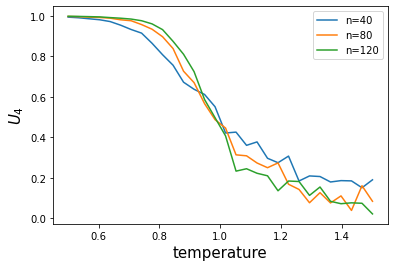

In [29]:
import matplotlib.pyplot as plt

for n,u4_beta in zip(n_list,u4_list_n):
    plt.plot(temp_list, np.array(u4_beta), label='n={}'.format(n))

plt.legend()
plt.ylabel('$U_4$', fontsize=15)
plt.xlabel('temperature', fontsize=15)
plt.show()

統計を十分に取っていないためデータにばらつきがありますが、おおよそ相転移点である温度が1付近で3つのシステムサイズのデータが1点で交わっていることが分かります。

Binder cumulantによる相転移点の推定は数値解析の最前線の研究でもよく用いられる手法です。

> 当然、学術的な研究をするためには、十分な統計を取るのはもちろん、誤差評価 (エラーバーの計算)なども真面目に行う必要があります。今回の計算は概要の説明だけにとどめてあるため、きっちりとした誤差評価等は省いてあります。